![ecommerce pic.jpg](attachment:083bb18f-a06a-4b82-a5df-096d3ebc0deb.jpg)

<center><span style="font-family:cursive;font-size:30px;"> Executive Summary</span></center>

## Goal:
- Predict customer churn using data collected from E-commerce

## About Data:
- The data set belongs to a leading online E-Commerce company. An online retail (E commerce) company wants to know the customers who are going to churn, so accordingly they can approach customer to offer some promos.
- 5630 rows, 20 columns
- About 17% customer churned in this data

## Data Cleaning
- Impute missing value with median
- Standardize categorical features
- Remove special characters from data
- Remove outlier using IQR
- One hot encode categorical features
- Min-max scaling

## Visualization
- Distribution of numerical feature by churn/no churn
- Proportion of churn in categorical features

## Modeling
- Train, test split (80%, 20%)
- Compare prediction performance using Logistic Regression and Random Forest
- Hyper-parameter tuning using Grid-search
- Feature selection using Recursive Feature Elimination with Cross Validation (RFECV)
- Hyper parameter tuning

## Conclusion
- The top 3 features to predict churn are: tenure, cashback amount, and distance from warehouse to home.
- Based on plots, it is difficult to create rule based model to predict churn, because the distribution of numerical features are quite similar among customer who churned and who did not churn
- Instead of using all features, we could select top 10 features to predict churn, and the prediction performance is similar to using all features for prediction
- Customers who are single, prefer order mobile devices, or filed complained tend to have higher proportion of churn.
- Prediction AUROC is 0.97 using Random Forest, 10 features

## Recommendation
- To reduce churn, the E-commerce company is suggested to:
    - Put more effort in engaging with customer
    - Provide more cashback amount
    - Set up more warehouse near customer residential area
    - Provide more channels for customer to provide feedback 

# Dashboard

![Dashboard 4.png](attachment:b5169fce-810a-4e4e-8f70-840b8b5afaa9.png)

# Import

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')
from google.colab import files
uploaded = files.upload()
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted


Saving E_comm.csv to E_comm.csv


In [2]:
import io
df = pd.read_csv(io.BytesIO(uploaded['E_comm.csv']))

# About the Dataset

In [3]:
df.shape

(5630, 20)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

### Each row is a unique customer

In [5]:
df.CustomerID.nunique()

5630

### There is no duplicate row

In [6]:
df.duplicated().sum()

0

### Missing data

Text(0.5, 1.0, 'Percentage of Missing Data')

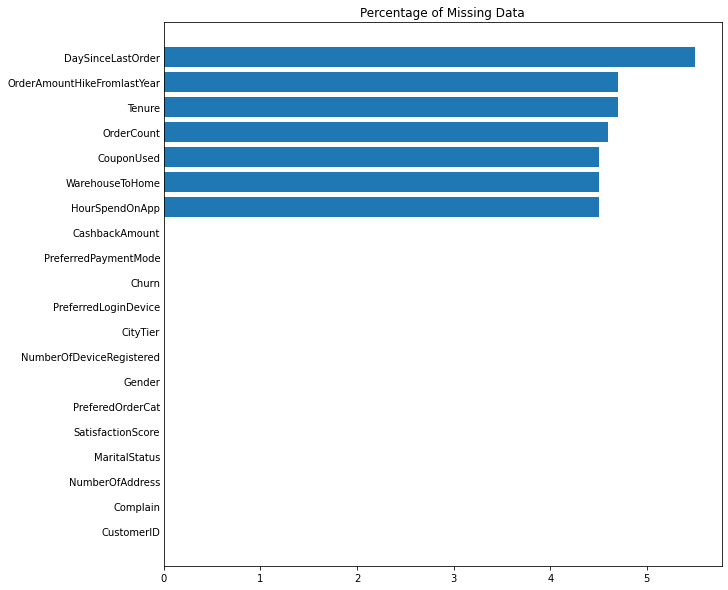

In [7]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': round(percent_missing,1)})
missing_value_df = missing_value_df.sort_values('percent_missing', ascending=True)
plt.figure(figsize=(10,10))
plt.barh(missing_value_df['column_name'],missing_value_df['percent_missing'])
plt.tick_params(axis='y', which='both',length=0)
plt.title('Percentage of Missing Data')

In [8]:
# Observe unique value for each column
# for i in df.columns:
#     print(i)
#     print(df[i].value_counts())
#     print()

# Cleaning

### Standardize categorical values for PreferredPaymentMode
- Eg. Some rows recorded 'CC', some 'Credit Card'

In [9]:
df['PreferredPaymentMode'].unique()

array(['Debit Card', 'UPI', 'CC', 'Cash on Delivery', 'E wallet', 'COD',
       'Credit Card'], dtype=object)

In [10]:
df['PreferredPaymentMode'] = df['PreferredPaymentMode'].str.replace('Cash on Delivery','COD')
df['PreferredPaymentMode'] = df['PreferredPaymentMode'].str.replace('Credit Card','CC')

In [11]:
# df = df.replace(' ', '_', regex=True)
# df = df.replace('&', 'And', regex=True)

### Categorize column types

In [12]:
binary_cat_cols = ['Complain']
outcome = ['Churn']
cat_cols = ['PreferredLoginDevice','Gender','PreferedOrderCat','MaritalStatus','CityTier']
num_cols = ['Tenure','WarehouseToHome','HourSpendOnApp','NumberOfDeviceRegistered','SatisfactionScore','NumberOfAddress','OrderAmountHikeFromlastYear',
           'CouponUsed','OrderCount','DaySinceLastOrder','CashbackAmount']

### Average proportion of Churn customers

In [13]:
df.Churn.mean()

0.16838365896980462

# Visualize 

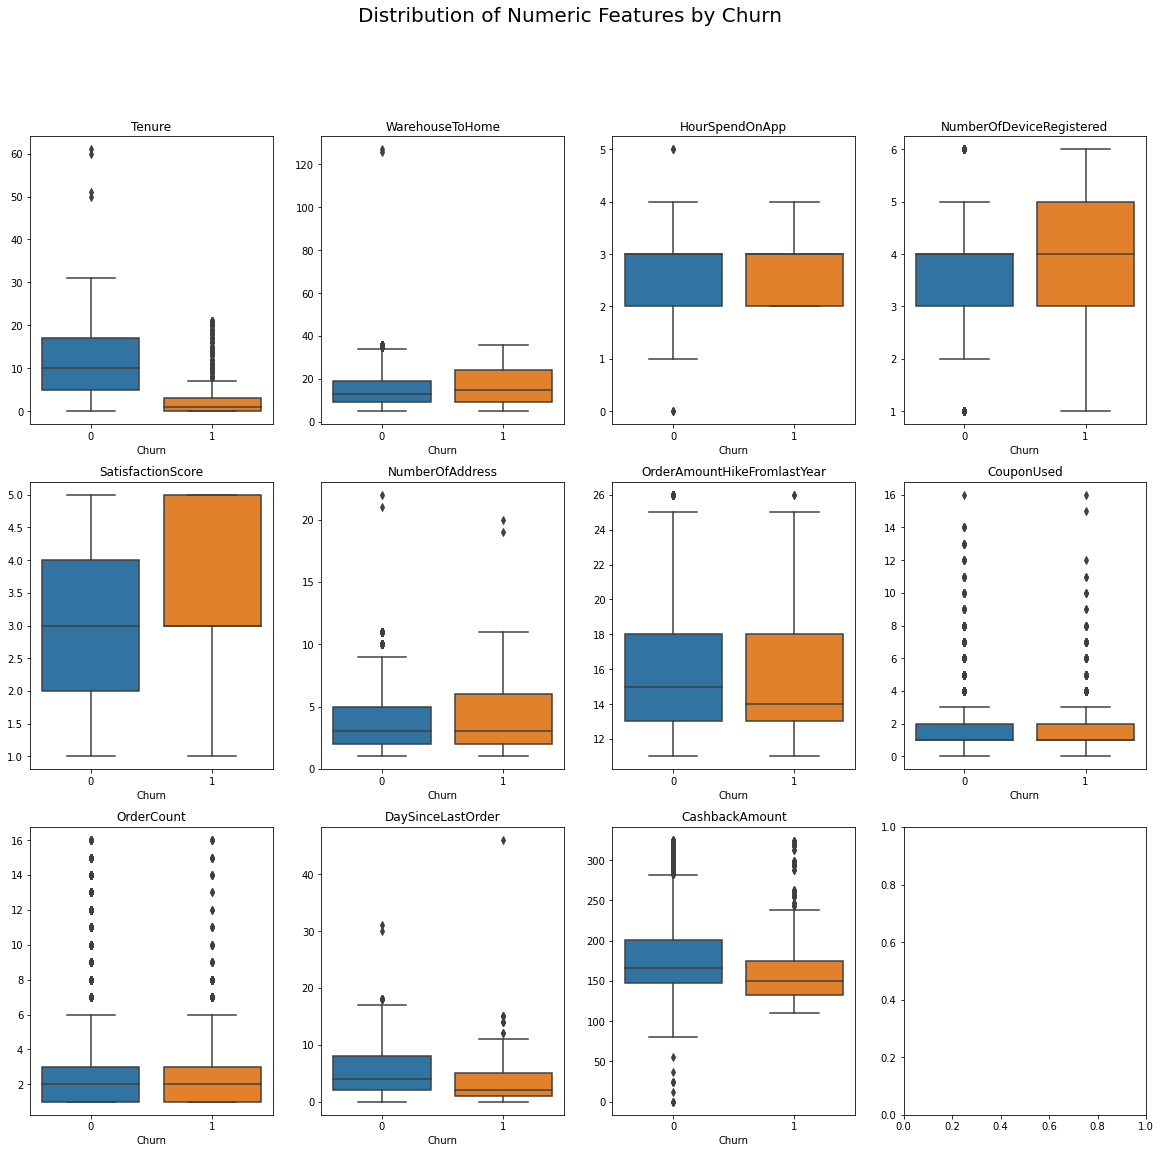

In [14]:
fig, ax = plt.subplots(3,4,figsize=(20, 18))
fig.suptitle('Distribution of Numeric Features by Churn', fontsize=20)
ax = ax.flatten()
for idx,c in enumerate(num_cols):
    df_t = df[df[c].notnull()].copy()
    ax[idx].set_title(c) 
    sns.boxplot(x='Churn', y=c, data=df_t, ax=ax[idx])
    ax[idx].set_ylabel('')
plt.show()

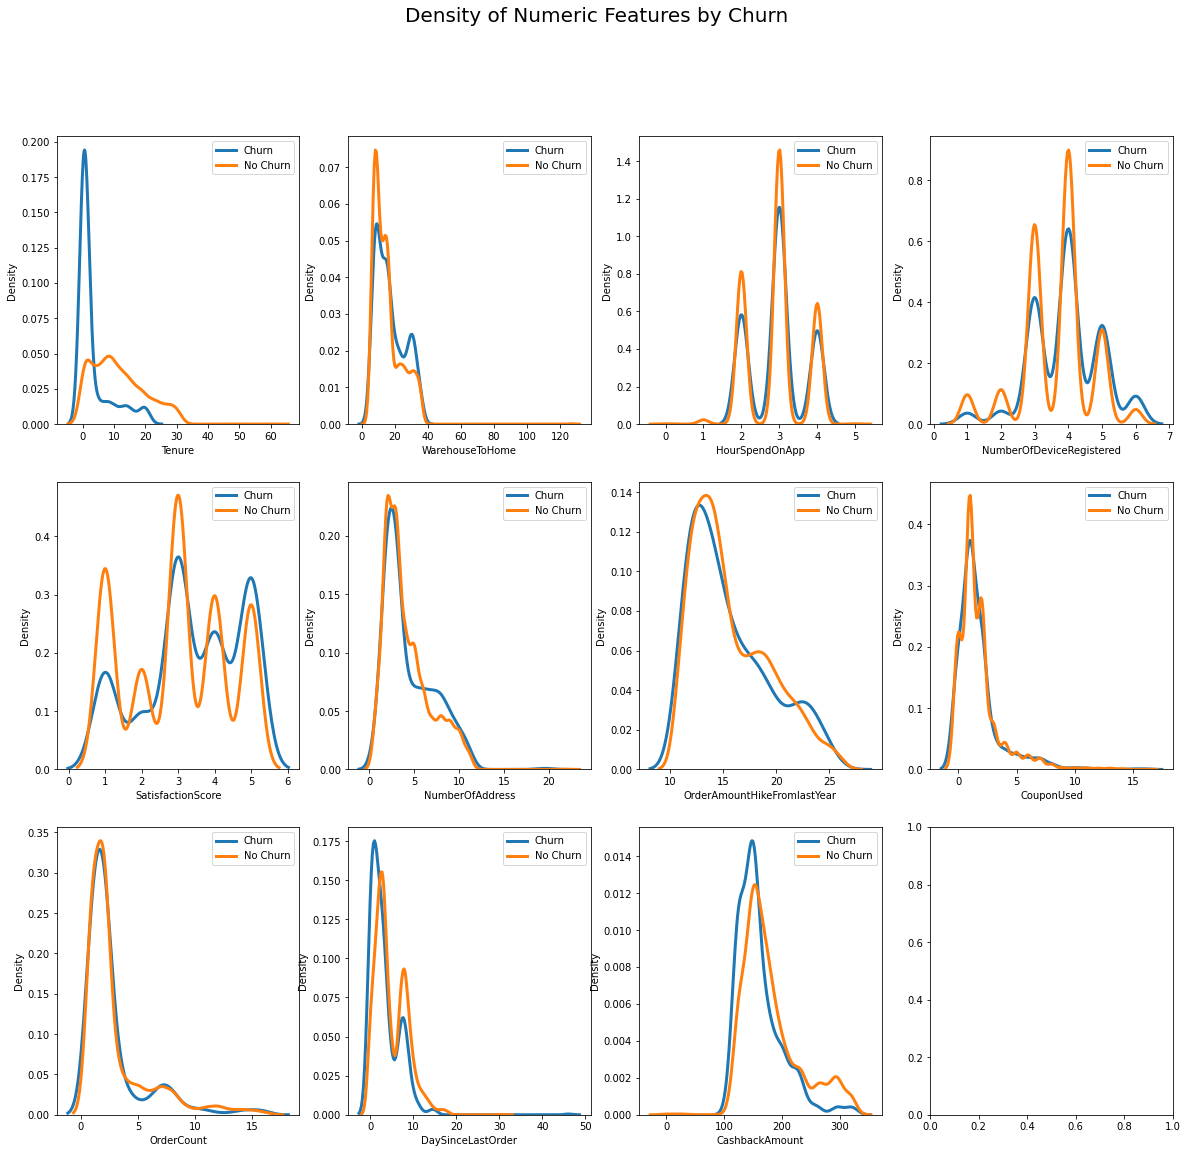

In [15]:
df_c = df[df['Churn']==1].copy()
df_nc = df[df['Churn']==0].copy()

fig, ax = plt.subplots(3,4,figsize=(20, 18))
fig.suptitle('Density of Numeric Features by Churn', fontsize=20)
ax = ax.flatten()

for idx,c in enumerate(num_cols):
    sns.kdeplot(df_c[c], linewidth= 3,
             label = 'Churn',ax=ax[idx])
    sns.kdeplot(df_nc[c], linewidth= 3,
             label = 'No Churn',ax=ax[idx])
    
    ax[idx].legend(loc='upper right')

plt.show()

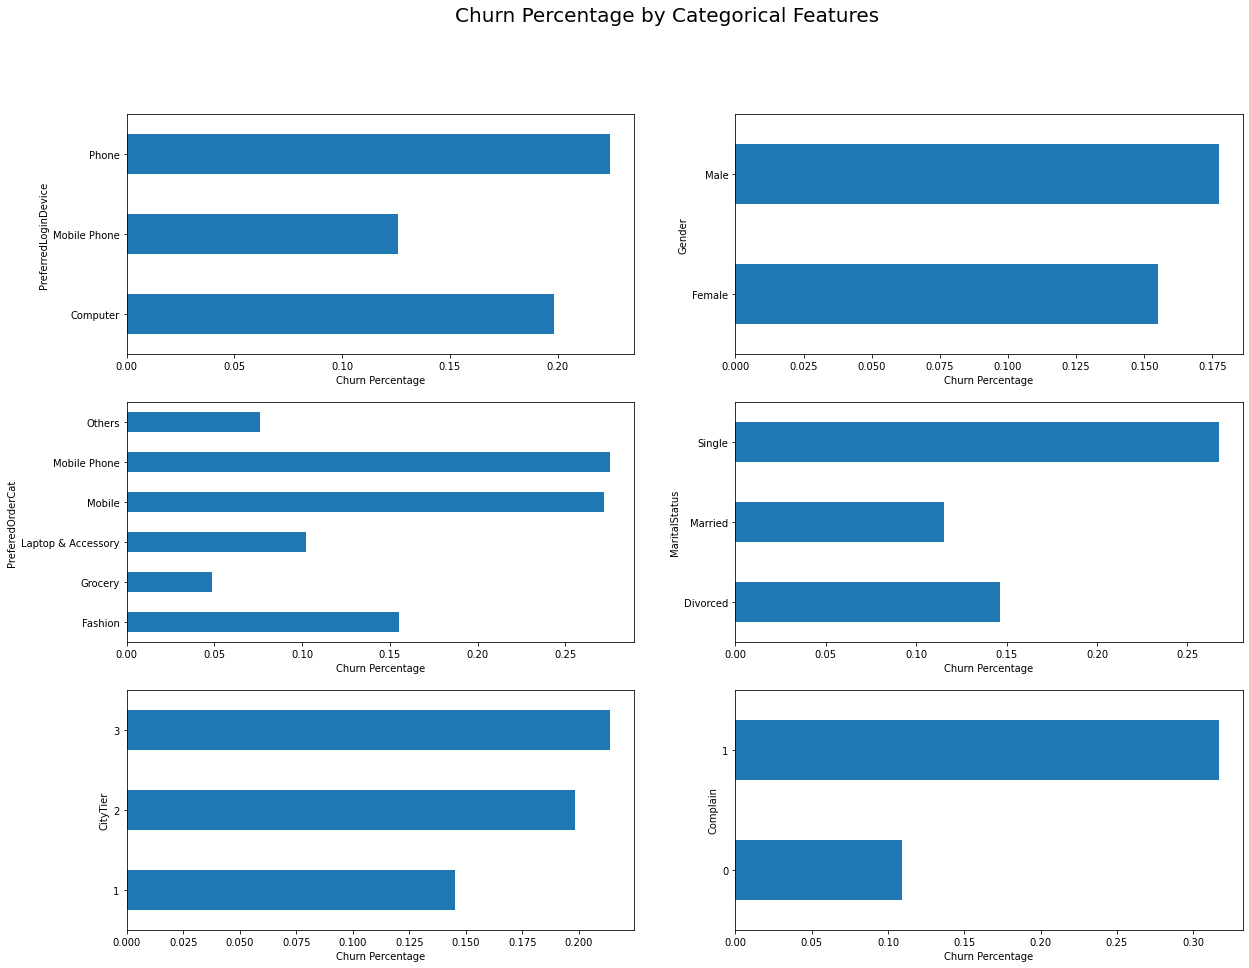

In [16]:
fig, ax = plt.subplots(3,2,figsize=(20, 15))
fig.suptitle('Churn Percentage by Categorical Features', fontsize=20)
ax = ax.flatten()

for idx,c in enumerate(cat_cols+binary_cat_cols):
    df.groupby(c).Churn.mean().plot.barh(ax=ax[idx])
    ax[idx].set_xlabel('Churn Percentage')
plt.show()

# Impute missing values

In [17]:
# impute with median
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Remove Outliers

In [18]:
def remove_outlier(df, col):    
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75) 
    IQR=Q3-Q1
    lr= Q1-(1.5 * IQR)
    ur= Q3+(1.5 * IQR)

    df[col]=np.where(df[col]>ur,ur,df[col])
    df[col]=np.where(df[col]<lr,lr,df[col])
    
    return df

for c in num_cols:
    df = remove_outlier(df, c)

# One Hot Encode Categorical Features

### Remove space and special character

In [19]:
df = df.replace(' ', '_', regex=True)
df = df.replace('&', 'And', regex=True)

In [20]:
df_encoded = pd.get_dummies(df,drop_first=True)
df_encoded.columns

Index(['CustomerID', 'Churn', 'Tenure', 'CityTier', 'WarehouseToHome',
       'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore',
       'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount',
       'PreferredLoginDevice_Mobile_Phone', 'PreferredLoginDevice_Phone',
       'PreferredPaymentMode_COD', 'PreferredPaymentMode_Debit_Card',
       'PreferredPaymentMode_E_wallet', 'PreferredPaymentMode_UPI',
       'Gender_Male', 'PreferedOrderCat_Grocery',
       'PreferedOrderCat_Laptop_And_Accessory', 'PreferedOrderCat_Mobile',
       'PreferedOrderCat_Mobile_Phone', 'PreferedOrderCat_Others',
       'MaritalStatus_Married', 'MaritalStatus_Single'],
      dtype='object')

# Split Train Test Set
- Train set (80%)
- Test set (20%)

In [21]:
X = df_encoded[['Tenure', 'CityTier', 'WarehouseToHome',
       'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore',
       'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount',
       'PreferredLoginDevice_Mobile_Phone', 'PreferredLoginDevice_Phone',
       'PreferredPaymentMode_COD', 'PreferredPaymentMode_Debit_Card',
       'PreferredPaymentMode_E_wallet', 'PreferredPaymentMode_UPI',
       'Gender_Male', 'PreferedOrderCat_Grocery',
       'PreferedOrderCat_Laptop_And_Accessory', 'PreferedOrderCat_Mobile',
       'PreferedOrderCat_Mobile_Phone', 'PreferedOrderCat_Others',
       'MaritalStatus_Married', 'MaritalStatus_Single']].copy()
y = df_encoded['Churn']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state=42)

# Min-Max Scaling

In [22]:
# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

# Modeling

### Random Forest

In [23]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

print(type(rfc))
scores = cross_val_score(rfc,X_train,y_train,cv=5, scoring='roc_auc')
print ("CV score :",scores.mean())
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)
print(classification_report(y_test, pred))

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score : 0.9753447869882825
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       941
           1       0.99      0.85      0.92       185

    accuracy                           0.97      1126
   macro avg       0.98      0.92      0.95      1126
weighted avg       0.97      0.97      0.97      1126



### Logistic Regression

In [24]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

print(type(lr))
scores = cross_val_score(lr,X_train,y_train,cv=5,scoring='roc_auc')
print ("CV score :",scores.mean())
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print(classification_report(y_test, pred))

<class 'sklearn.linear_model._logistic.LogisticRegression'>
CV score : 0.8781523708545859
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       941
           1       0.80      0.52      0.63       185

    accuracy                           0.90      1126
   macro avg       0.85      0.75      0.79      1126
weighted avg       0.89      0.90      0.89      1126



### Random Forest performs better than Logistic Regression
- Fine tune hyper parameters for Random Forest

In [25]:
gs_rfc = GridSearchCV(RandomForestClassifier(random_state=42), {'max_depth': [2, 5, 8, 10, 12, 15, 20, 30, 50],
                                                 'n_estimators': [5, 10, 20, 30, 50, 100,200]},
                      verbose=1, cv=5) # make sure cv condition same as actual fitting for training set

gs_rfc.fit(X_train, y_train)

# select the best estimator
print('Best score:', gs_rfc.best_score_, '(Not much different from default parameters)')
print('Best parameters:', gs_rfc.best_params_)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
Best score: 0.9529345172031076 (Not much different from default parameters)
Best parameters: {'max_depth': 30, 'n_estimators': 200}


### Adding categorical features did not improve performance

# Feature Selection
- Observe how number of features affect prediction performance

In [26]:
rfecv = RFECV(estimator=RandomForestClassifier(random_state=42),
             step=1,
             cv=5,
              scoring='roc_auc')

# [Checked] Adding categorical features did not improve performance
rfecv.fit(X_train, y_train)

RFECV(cv=5, estimator=RandomForestClassifier(random_state=42),
      scoring='roc_auc')

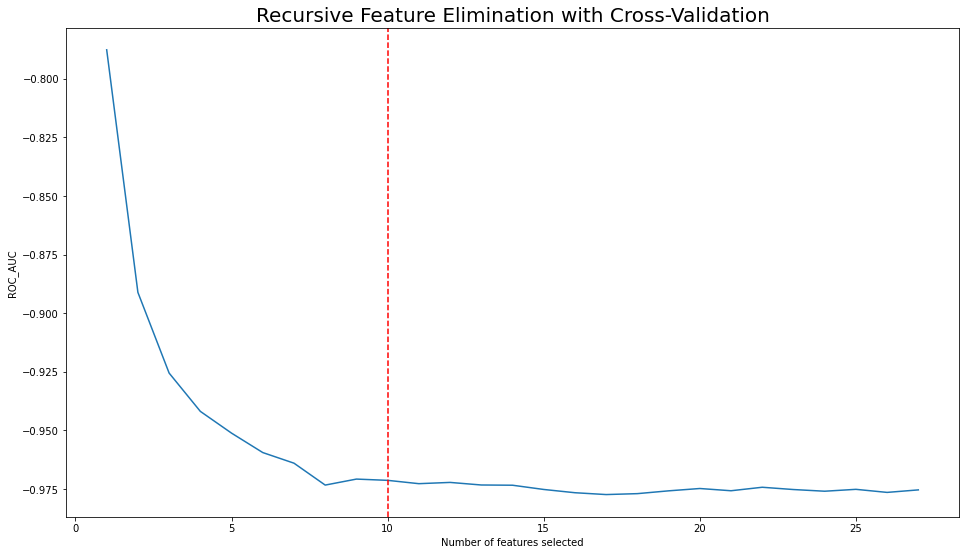

In [27]:
plt.figure(figsize=(16,9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=20)
plt.xlabel('Number of features selected')
plt.ylabel('ROC_AUC')
plt.plot(range(1,len(rfecv.grid_scores_)+1), [-i.mean() for i in rfecv.grid_scores_])
plt.axvline(x = 10, color = 'r', linestyle='dashed')
plt.show()

# 10 features seems sufficient, more features does not significantly improve performance

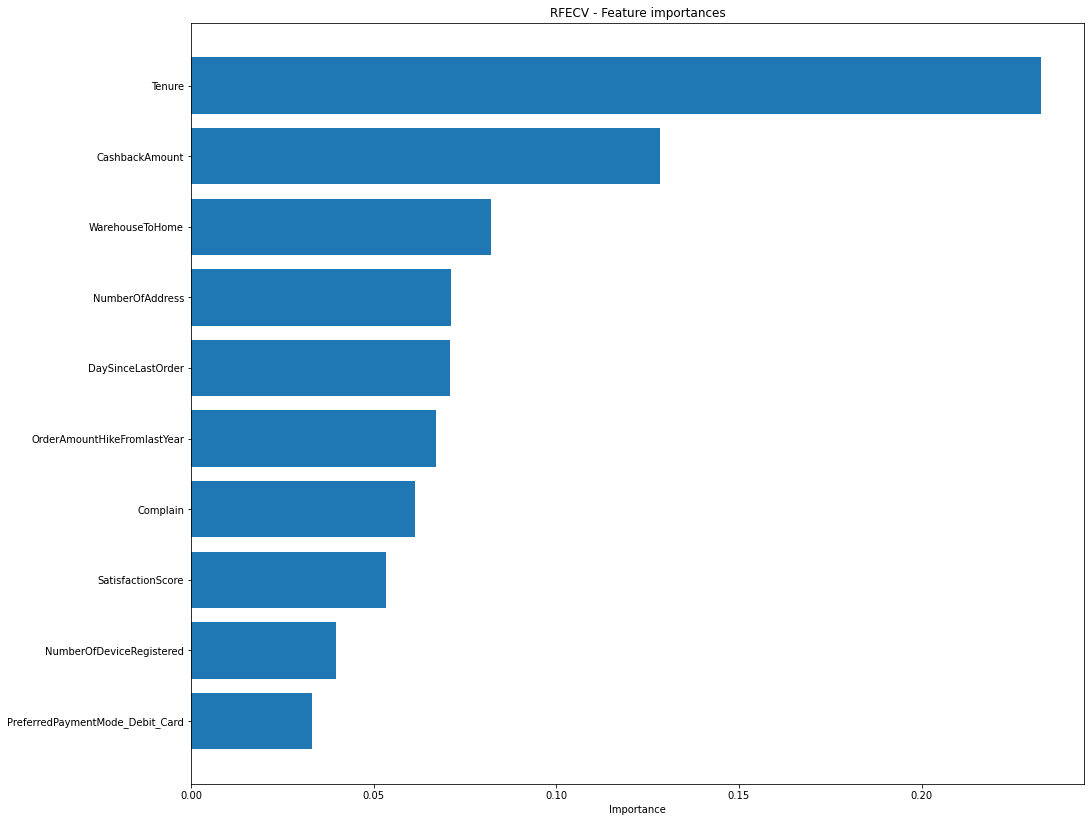

In [28]:
dset = pd.DataFrame()
dset['attr'] = list(X_train.columns)[:len(rfecv.estimator_.feature_importances_)]
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance',ascending=True).tail(10)


plt.figure(figsize=(16,14))
plt.barh(y=dset['attr'],width=dset['importance'])
plt.title('RFECV - Feature importances')
plt.xlabel('Importance')
plt.show()

In [29]:
selected_cols = list(dset['attr'])
rfc = RandomForestClassifier(random_state=42)

print(type(rfc))
scores = cross_val_score(rfc,X_train[selected_cols],y_train,cv=5, scoring='roc_auc')
print ("CV score :",scores.mean())
rfc.fit(X_train[selected_cols], y_train)
pred = rfc.predict(X_test[selected_cols])
print(classification_report(y_test, pred))

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score : 0.973522539688213
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       941
           1       0.98      0.88      0.93       185

    accuracy                           0.98      1126
   macro avg       0.98      0.94      0.96      1126
weighted avg       0.98      0.98      0.98      1126



### Using top 10 features could yield similar prediction performance as using all features